<a href="https://colab.research.google.com/github/uscmlsystems/ml-systems-hw2-Lvyuche/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 599 HW 2: Convolution Neural Network

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

In [2]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

Verify that GPU is availble to use.

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device", device)

Device cuda


## Convolution Operation

Definition:
Convolution is a mathematical operation where a filter (or kernel) is applied over an input (e.g., image) to produce a modified output known as a feature map.

Key Components:
- Kernel/Filter: A small matrix that slides over the input. It captures patterns or features from the input.
  
- Stride: The number of pixels the filter moves at each step.
  
- Padding: Zeros added around the input's border, often used to control the output's spatial dimensions.

Operation:
The filter starts at the top-left corner of the image. For each position, values under the filter are multiplied with its corresponding filter values, then summed to produce a single pixel in the output. This process is repeated across the entire input.

## Create a sample image

Create a 3D  `image` of shape `(1,10,10)` as a numpy-array. The signal values are 1 (white) in the `(4,4)`-center region and 0 (black) elsewhere.

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

In [4]:
# Create a 1x10x10 image filled with zeros
image = np.zeros((1, 10, 10), dtype=np.float32)

# Set a 4x4 sub-matrix (starting from index 3 to 7 both for rows and columns) to be filled with ones
image[0, 3:7, 3:7] = 1

# Print the formatted matrix
print(image)
print(image.shape)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(1, 10, 10)


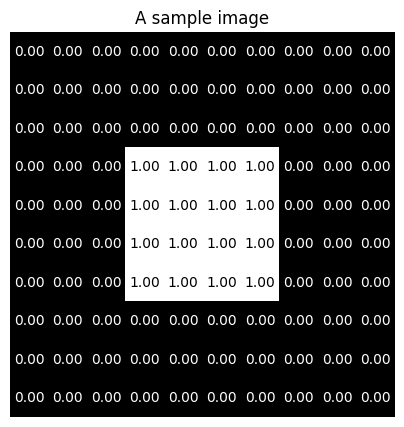

In [5]:
def plot_image_with_values(image, title):
    """
    Plots a 3D image with numeric values overlaid on each cell.

    Parameters:
    - image (3D numpy array): The image to be plotted.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(5,5))

    # Plot the image
    plt.imshow(image[0], cmap='gray')

    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            pixel_value = image[0, i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)

    plt.title(title)
    plt.axis('off')
    plt.show()


plot_image_with_values(image, 'A sample image')

## Average Filter

### **TODO 1**:
Implement a function that applies a 3x3 average filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. The filter should have all values set to 1/9, ensuring the sum is 1, and use a padding of 1 to keep the output image dimensions the same as the input.

Note that the input and output of the `average_filter` function are numpy array type, so you need to convert numpy array to pytorch tensor, process the tensor, and convert pytorch tensor back to numpy array.

In [6]:
def average_filter(image):
    """
    Apply a 3x3 average filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter = filter / 9

    image = torch.from_numpy(image).view(1, 1, 10, 10)

    tensor = nn.functional.conv2d(image, filter, stride=1, padding=1)

    filtered_img = tensor.view(1, 10, 10).detach().numpy()

    return filtered_img

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

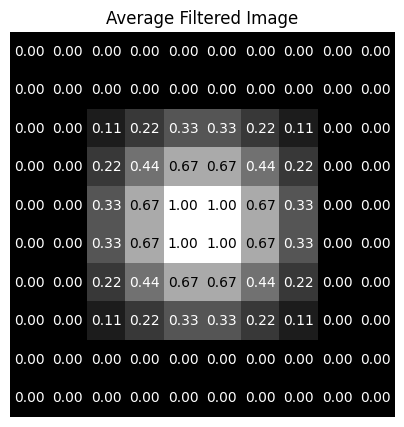

In [7]:
filtered_img = average_filter(image)
plot_image_with_values(filtered_img, 'Average Filtered Image')

## Edge Detection

In image processing, edge detection refers to the process of identifying abrupt changes or discontinuities in an image. These abrupt changes often correspond to object boundaries, textures, or other significant features.

The concept of **central differences** can be applied to images to detect edges by estimating the gradient magnitude at each pixel. In the context of images, the derivative approximations can highlight the areas of rapid intensity change, which are often the edges.

Using the concept of central differences, one possible filter for vertical edge detection is:
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}

### **TODO 2**:
Implement a function that applies a 3x3 vertical edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [8]:
from re import I
def vertical_edge_detection(image):
    """
    Apply a 3x3 vertical edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter[0, 0, :, 0] = -1
    filter[0, 0, :, 1] = 0
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 10, 10)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 10, 10).detach().numpy()

    return filtered_img

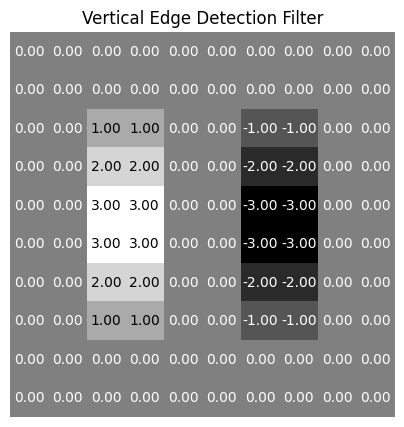

In [9]:
filtered_img = vertical_edge_detection(image)
plot_image_with_values(filtered_img, 'Vertical Edge Detection Filter')

## Horizontal Edge

### **TODO 3:**
Implement a function that applies a 3x3 horizontal edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. What should the filter be in this case?

In [10]:
def horizontal_edge_detection(image):
    """
    Apply a 3x3 horizontal edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter[0, 0, 0, :] = -1
    filter[0, 0, 1, :] = 0
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 10, 10)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 10, 10).detach().numpy()

    return filtered_img

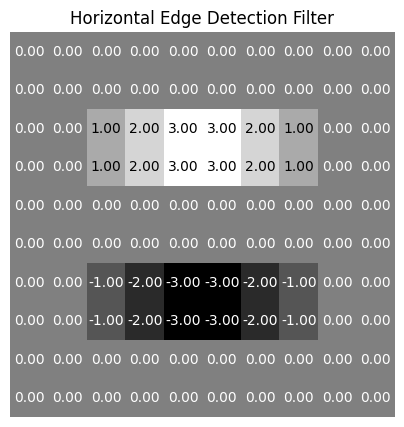

In [11]:
filtered_img = horizontal_edge_detection(image)
plot_image_with_values(filtered_img, 'Horizontal Edge Detection Filter')

## Laplacian Sharpening
Lapalacian filters can increase the regions of the image with rapid intensity. It is very helpful in hiding the fine details of images. Any features with a sharp discontunioty will be enhanced.

One of the Laplacian filter is

\begin{bmatrix}
 0 & -1 &  0 \\
-1 &  5 & -1 \\
 0 & -1 &  0 \\
\end{bmatrix}


### **TODO 4**:
Implement a function that applies a 3x3 laplacian sharpening filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [12]:
def laplacian_filter(image):
    """
    Apply a 3x3 laplacian filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.zeros(1, 1, 3, 3)
    filter[0, 0, :, 1] = -1
    filter[0, 0, 1, :] = -1
    filter[0, 0, 1, 1] = 5
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 10, 10)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 10, 10).detach().numpy()

    return filtered_img

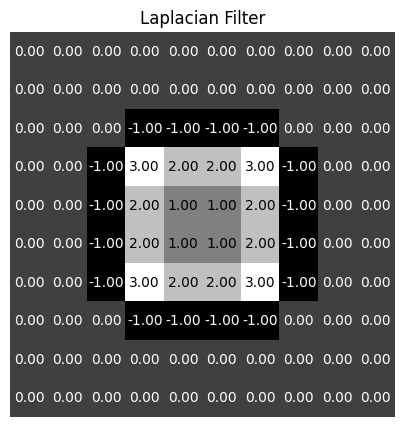

In [13]:
filtered_img = laplacian_filter(image)
plot_image_with_values(filtered_img, 'Laplacian Filter')

## Applying Filters on a Real Image

In this section we apply several filters on a real image.

Use `PIL` library to read a image from online resource called `sheep.jpg` as a numpy array. Convert that image to grayscale so that it only has a single channel and plot the image.

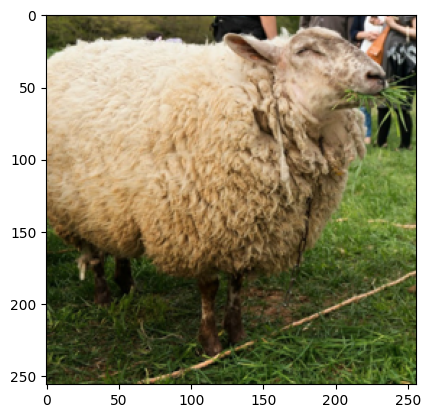

In [14]:
from PIL import Image
import urllib.request

image = Image.open(urllib.request.urlopen('https://chokkan.github.io/deeplearning/assets/images/sheep.jpg'))
image = image.resize((256, 256))  # resize image.
plt.imshow(image)

image = image.convert('L')  # convert to grey scale
image = np.array(image, dtype=np.float32) / 255  # normalize image to range [0, 1]
image = np.expand_dims(image, axis=0)  # expand to 3 dimensional

Create a function that can plot both the original image and its modified version side by side.

In [15]:
def plot_original_and_modified(original_img, modified_img):
    """
    Plot the original image and its modified version side by side.

    Args:
    - original_img: A 3D numpy array representing the original image.

    - modified_img: A 3D numpy array representing the the modified version of the original image.
    """

    # Ensure that the input arrays are in the range [0, 1]
    original_img = np.clip(original_img, 0, 1)[0]
    modified_img = np.clip(modified_img, 0, 1)[0]

    plt.figure(num=None, figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')

    # Plot the original image
    plt.subplot(1,2,1)
    plt.imshow(original_img, cmap='Greys_r')
    plt.title("Original Image")

    # Plot the modified image
    plt.subplot(1,2,2)
    plt.imshow(modified_img, cmap='Greys_r')
    plt.title("Modified Image")

    plt.show()

### **TODO 5**:
Implement a function that applies a 3x3 vertical edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

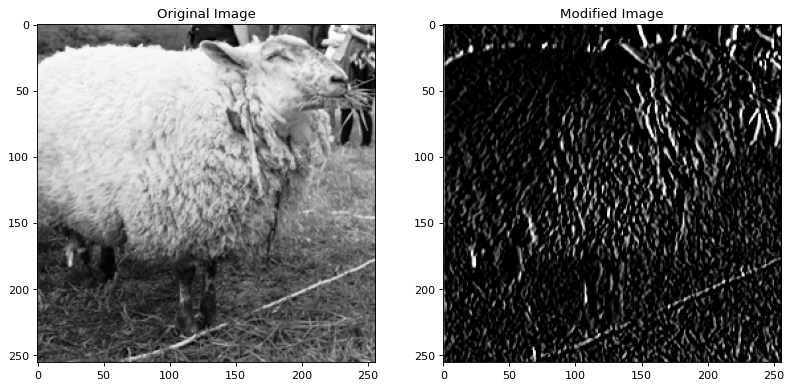

In [16]:
def vertical_edge_detection(image):
    """
    Apply a 3x3 vertical edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter[0, 0, :, 0] = -1
    filter[0, 0, :, 1] = 0
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 256, 256)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 256, 256).detach().numpy()

    return filtered_img

filtered_img = vertical_edge_detection(image)
plot_original_and_modified(image, filtered_img)

### **TODO 6:**
Implement a function that applies a 3x3 horizontal edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

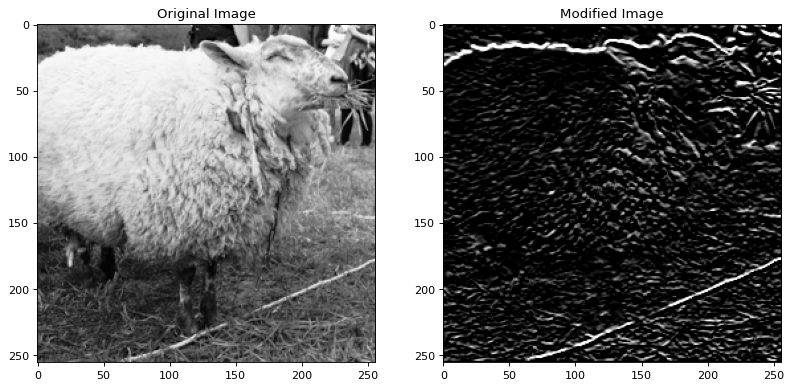

In [17]:
def horizontal_edge_detection(image):
    """
    Apply a 3x3 horizontal edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter[0, 0, 0, :] = -1
    filter[0, 0, 1, :] = 0
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 256, 256)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 256, 256).detach().numpy()

    return filtered_img

    return filtered_img

filtered_img = horizontal_edge_detection(image)
plot_original_and_modified(image, filtered_img)

### **TODO 7:**
Implement a function that applies a 3x3 laplacian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

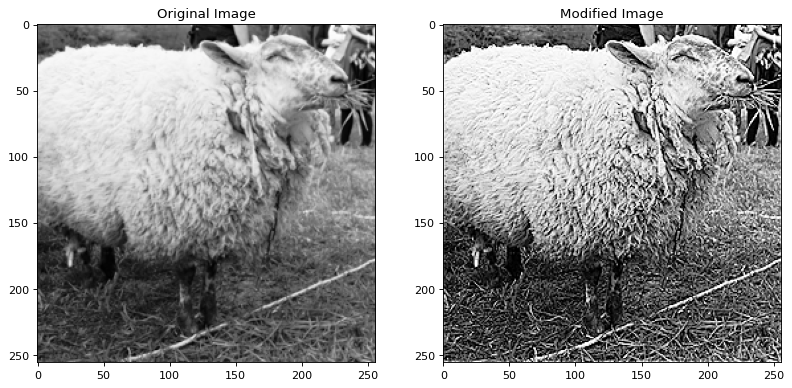

In [18]:
def laplacian_filter(image):
    """
    Apply a 3x3 laplacian filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.zeros(1, 1, 3, 3)
    filter[0, 0, :, 1] = -1
    filter[0, 0, 1, :] = -1
    filter[0, 0, 1, 1] = 5
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 256, 256)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 256, 256).detach().numpy()

    return filtered_img

filtered_img = laplacian_filter(image)
plot_original_and_modified(image, filtered_img)

### Gaussian Filter for Blurring

The Gaussian filter is commonly used for blurring image. Its values are determined by the Gaussian function, resulting in a weighted average that emphasizes the central pixel and decreases the influence of neighboring pixels as the distance increases.

The specific weights for the 3x3 Gaussian filter are arranged as follows, ensuring that the sum of all weights is equal to 1, which preserves the overall brightness of the image:

\begin{bmatrix}
1/16 & 2/16 & 1/16 \\
2/16 & 4/16 & 2/16 \\
1/16 & 2/16 & 1/16 \\
\end{bmatrix}

This arrangement of weights creates a bell-shaped curve, centralizing the focus on the middle pixel while progressively giving less importance to pixels further away.

### **TODO 8:**
Implement a function that applies a 3x3 gaussian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

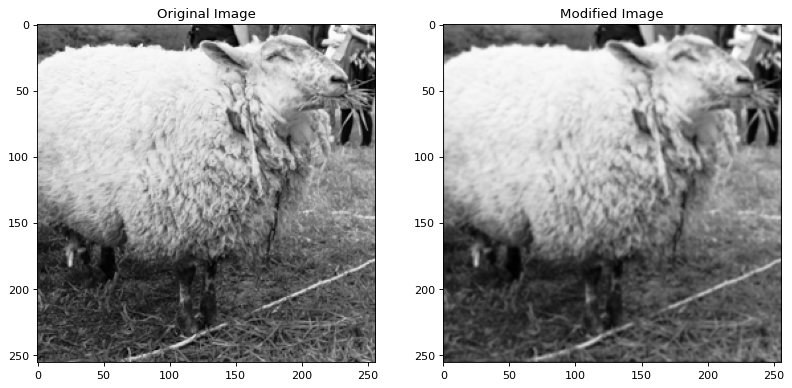

In [19]:
def gaussian_filter(image):
    """
    Apply a 3x3 gaussian filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    filter = torch.ones(1, 1, 3, 3)
    filter[0, 0, :, 1] = 2
    filter[0, 0, 1, :] = 2
    filter[0, 0, 1, 1] = 4
    filter = filter / 16
    # print(filter)

    image = torch.from_numpy(image).view(1, 1, 256, 256)

    tensor = nn.functional.conv2d(image, filter, stride = 1, padding = 1)

    filtered_img = tensor.view(1, 256, 256).detach().numpy()

    return filtered_img

filtered_img = gaussian_filter(image)
plot_original_and_modified(image, filtered_img)

## Pooling

Pooling is an operation frequently used in the context of Convolutional Neural Networks (CNNs) for image processing. The main idea behind pooling is to reduce the spatial size of the representation, thereby reducing the number of parameters and computational complexity in the network. This helps in making the network less prone to overfitting and also reduces computation time.

There are several types of pooling operations, with the most common ones being:

**Max Pooling**: In this method, for each segment of the input, the maximum value is selected. For instance, if we consider a 2x2 pooling window (often called a "kernel" in this context) and slide it over an image tensor, the largest value within each 2x2 window will be selected for the pooled output.

**Average Pooling**: Instead of taking the maximum value in each window, average pooling takes the average value. So for a 2x2 window, it would take the average of all 4 values in that window.

**Min Pooling**: This operation selects the minimum value from each window, though it's less commonly used than max or average pooling.

**Global Pooling**: Instead of using a fixed size window, global pooling operates over the entire height and width of the feature map, effectively transforming the spatial dimensions of the feature map to 1x1 (retaining the depth/channels).

The main benefits of pooling include:

- **Dimensionality Reduction**: It reduces the spatial dimensions of the feature maps, which in turn reduces the number of parameters in subsequent layers, leading to faster computations.
- **Invariance to Small Translations**: Small translations in the input image might not lead to significant changes in the pooled feature map. This can be particularly useful when the exact location of features is less relevant than their presence.
- **Prevents Overfitting**: By reducing the spatial resolution and thus the total number of parameters, pooling can help prevent overfitting.


### **TODO 9:**
Implement a function that applies a 5x5 max pooling filter with stride 5 to an input image using PyTorch's [max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) function.

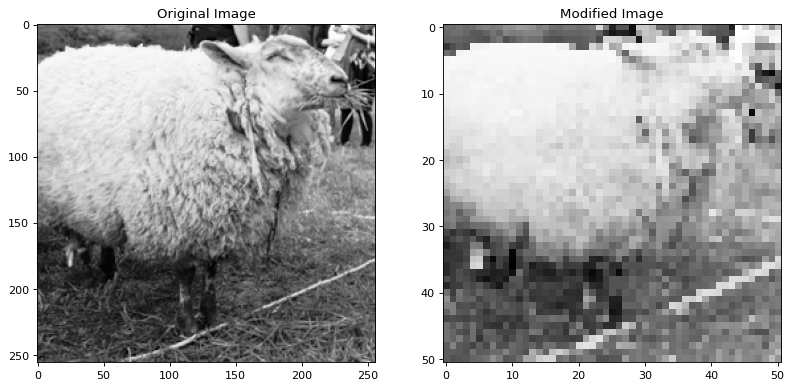

In [21]:
def max_pooling(image):
    """
    Apply a 5x5 max pooling to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    image = torch.from_numpy(image).view(1, 1, 256, 256)
    tensor = nn.functional.max_pool2d(image, 5, 5)

    filtered_img = tensor.view(1, 51, 51).detach().numpy()

    return filtered_img

filtered_img = max_pooling(image)
plot_original_and_modified(image, filtered_img)

### **TODO 10:**
Implement a function that applies a 5x5 average pooling filter with stride 5 to an input image using PyTorch's [avg_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html) function.

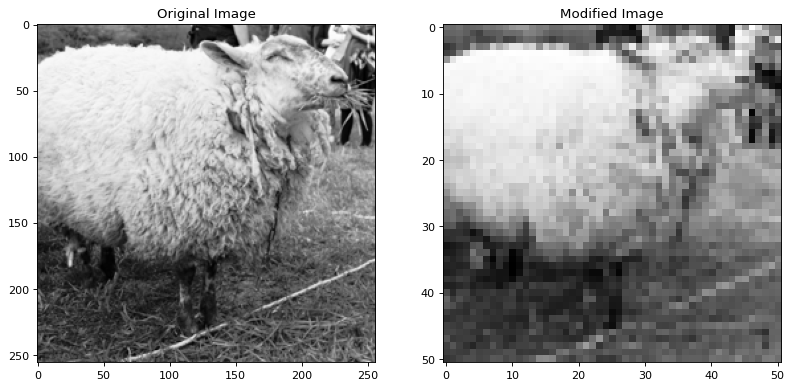

In [22]:
def average_pooling(image):
    """
    Apply a 5x5 average pooling to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    image = torch.from_numpy(image).view(1, 1, 256, 256)
    tensor = nn.functional.avg_pool2d(image, 5, 5)

    filtered_img = tensor.view(1, 51, 51).detach().numpy()

    return filtered_img

filtered_img = average_pooling(image)
plot_original_and_modified(image, filtered_img)

## Convolutional Neural Networks

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

In [23]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root="./", train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root="./", train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13225596.54it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Let's view some of the images.

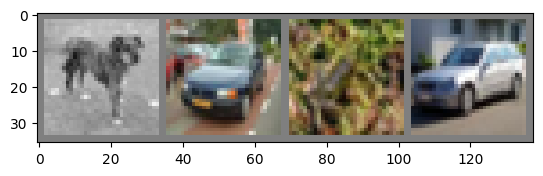

Labels: dog   car   frog  car  


In [24]:
# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()

    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **TODO 11:**

Implement a simple CNN model with the architecure defined in the comments to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset comprises 3x32x32 pixel RGB color images with 10 distinct categories.

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pooling = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.linear1 = nn.Linear(16 * 5 * 5, 120)

        # Second fully connected layer: 120 input features, 84 output features
        self.linear2 = nn.Linear(120, 84)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pooling(x)

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pooling(x)

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        # x = torch.flatten(x, 1)
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = self.linear1(x)
        x = F.relu(x)

        # Apply second fully connected layer, followed by ReLU activation
        x = self.linear2(x)
        x = F.relu(x)

        # Apply third fully connected layer (output layer)
        x = self.linear3(x)

        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)

### **TODO 12:**

Implement the training loop for your CNN model. The loop should feed input data to the model, compute the loss using the correct labels, and update the model weights using an optimization algorithm.

In [52]:
def train(model: nn.Module, dataloader: DataLoader, epoch_num: int):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the loss criterion and optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoch_num):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            [inputs, labels] = data
            # Move inputs to the specified device
            inputs = inputs.to(device)
            # Move labels to the specified device
            labels = labels.to(device)
            # Zero the gradients in the optimizer
            optimizer.zero_grad()
            # Forward pass through the model
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Compute gradients
            loss.backward()
            # Update model parameters
            optimizer.step()
            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete

Train this CNN on the training dataset with 3 epoch (this may take a few moments).

In [53]:
train(net, trainloader, 2)

[1,  2000] loss: 2.157
[1,  4000] loss: 1.844
[1,  6000] loss: 1.682
[1,  8000] loss: 1.600
[1, 10000] loss: 1.508
[1, 12000] loss: 1.449
[2,  2000] loss: 1.368
[2,  4000] loss: 1.373
[2,  6000] loss: 1.320
[2,  8000] loss: 1.282
[2, 10000] loss: 1.247
[2, 12000] loss: 1.263
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

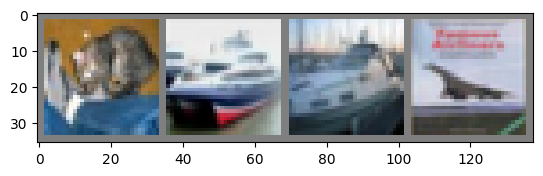

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  truck ship 


In [54]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net.cuda()
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Let us look at how the network performs on the whole dataset.


In [55]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.13%


### **TODO 13:**
1. In the CNN model we have created, how many layers have trainable weights? Please list all the dimensions of each layer's weights.

2. For each of the layers with traiable weights, please list their input and output dimension.

3. The outputs of a neural network before the activation function is applied are named as "logits". For multi-class clasification, we know that we need to apply softmax activation function to logits and then compute cross-entropy loss on it. However, in our `Net` class where we define the model architecture, we haven't explicitly initialized a softmax function or applied it to the model's final output within the forward function. Can you explain why by referring to PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) documentation?

4. Why is cross-entropy loss prefered over MSE loss for multi-class classification?

5. Suppose we have a vector of logits `Z`, with a dimension of `M`. This dimension corresponds to the number of output classes in a classification task, such as the Cifar10 classification task where `M` = 10. First, we apply the softmax function to the logits `Z`, which yields a vector of predicted probabilities for each class, denoted as `P`. Then, we compute the cross-entropy loss, denoted as `L`, using the probabilities vector `P` and the true class labels `Y`, which are provided in the form of a one-hot encoded vector of the same length `M`. Derive the gradient of the loss `L` with respect to the logits `Z`, namely `dL/dZ`.

Your answer:

1. Five layers have trainable weights, including 2 convolutional layers and 3 fully connected layers.
Pytorch: (C_out, C_in, K_height, K_width)
Conv1: (6, 3, 5, 5)
Conv2: (16, 6, 5, 5)
fc1: (120, 16 * 5 * 5)
fc2: (84, 120)
fc3: (10, 84)     
2. As follow:   
Conv1's input dimension: 3 Conv1's output dimension: 6    
Conv2's input dimension: 6 Conv2's output dimension: 16  
fc1's input dimension: 16 * 5 * 5 fc1's output dimension: 120  
fc2's input dimension: 120 fc2's output dimension: 84  
fc3's input dimension: 84 fc3's output dimension: 10

3. This is because CrossEntropyLoss internally combines both the softmax activation and the calculation of the Negative Log Likelihood Loss in a single step. This approach not only simplifies the implementation but also improves numerical stability and computational efficiency.   
4. Cross-entropy directly measures the dissimilarity between the actual distribution of labels and the predicted probabilities, providing a clear and direct metric for evaluating classification performance. Therefore, cross-entropy loss tends to produce more informative gradients than MSE  
5. Given a vector of logits `Z` for `M` classes and applying softmax to obtain probabilities `P`, where $$P_i = \frac{e^{z_i}}{\sum_{j=1}^{M} e^{z_j}},$$ and computing cross-entropy loss `L` with true labels `Y` in one-hot encoded form, $$L = -\sum_{i=1}^{M} Y_i \log(P_i),$$ the gradient of `L` with respect to `Z` is derived as follows. The partial derivative of `L` with respect to a logit `z_k` is $$\frac{\partial L}{\partial z_k} = P_k - Y_k.$$ Thus, the gradient of the loss with respect to the logits is $$\frac{dL}{dZ} = P - Y.$$ This shows that the gradient needed for updating `Z` is the difference between the predicted probabilities and the true labels.
